In [8]:
%matplotlib inline

In [9]:
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import os 
import pandas as pd
from sklearn.model_selection import train_test_split

In [10]:
pwd

'/home/andre/PycharmProjects/geonumerics/ipython_notebooks/Stocks/data'

In [11]:
cd data

[Errno 2] No such file or directory: 'data'
/home/andre/PycharmProjects/geonumerics/ipython_notebooks/Stocks/data


In [13]:
X = pd.read_pickle('PETR4_xtrain.pickle')
y = pd.read_pickle('PETR4_ytrain.pickle')

In [14]:
# change here if you wish OPTIONS
# shift=60
nforecast=60
nvalidation=nforecast # to validate the model prior prediction
ntraining = 5*8*60 # 5*8 hours before for training - 1 week or 8 hours
nwindow = nvalidation+nforecast+ntraining 

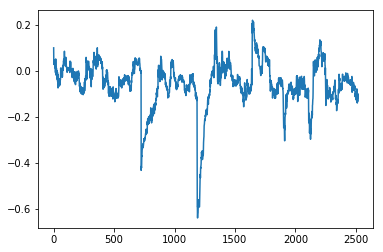

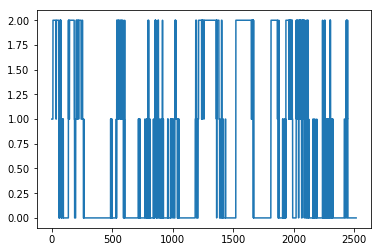

In [17]:
plt.plot(X[1:nwindow].dema_2VALE3_C.values)
plt.figure()
plt.plot(y[1:nwindow].values)

In [21]:
tf.one_hot(y.values.astype(np.int32), depth=3)

<tf.Tensor 'one_hot_1:0' shape=(228444, 3) dtype=float32>

In [8]:
def hot_encode(Y):
    """hot enconde ternary classes [0, 1, 2]"""
    size = len(Y)
    
    y_tmp = Y.apply(lambda x: np.array([1, 0]) if x==0 else np.array([0, 1]))
    return np.concatenate(y_tmp.values).reshape(size, 3)

def decode_hot(pred):
    """decode binary classification by higher probability"""
    pred_y = np.apply_along_axis(lambda x: 0 if x[0] > 0.5 else 1, axis=1, arr=pred)
    prob = np.apply_along_axis(lambda x: x[0] if x[0] > 0.5 else x[1], axis=1, arr=pred)
    return prob, pred_y

def append_bias(features, target):
    """append bias on features hot enconde target variable (label)"""
    n_samples = features.shape[0]
    n_features = features.shape[1]
    intercept_feature  = np.ones((n_samples,1))
    X = np.concatenate((features,intercept_feature),axis=1)
    X = np.reshape(X,[n_samples, n_features+1])
    Y = hot_encode(target)
    return X, Y

In [9]:
tf.reduce_max?

In [13]:
%%time
    graph = tf.Graph()
    with graph.as_default():
        
        keep_prob = tf.placeholder(tf.float32)  # DROP-OUT here
        # Create placeholders for training input and output labels
        # features or X's shape [len, nfeatures]
        x_ = tf.placeholder(tf.float32, shape=[None,318], name="x-input")
        # labels or classes for training (hot encoded)
        y_ = tf.placeholder(tf.int32, shape=[None, 2], name="y-input")
        
        #Define the weights to the hidden and output layer respectively.
        w1 = tf.Variable(tf.random_uniform([318, 190], -.5, .5), name="Weights1")    
        w2 = tf.Variable(tf.random_uniform([190, 30], -.5, .5), name="Weights2")
        w3 = tf.Variable(tf.random_uniform([30, 2], -.5, .5), name="Weights2") 
        # output size 2 (hot encoded) classes [0, 1]
        #w4 = tf.Variable(tf.random_uniform([64, 2], -.5, .5), name="Weights2") 
        # Define the bias to the hidden and output layers respectively
        #b1 = tf.Variable(tf.zeros([2]), name="Bias1")
        #b2 = tf.Variable(tf.zeros([1]), name="Bias2")                
        # Define the final output through forward pass
        z1 = tf.nn.sigmoid(tf.matmul(x_, w1))
        z2 = tf.nn.relu(tf.matmul(z1, w2))
        w2 = tf.nn.dropout(w2, keep_prob)  # DROP-OUT here
        z3 = tf.nn.sigmoid(tf.matmul(z2, w3)) 
         # output layer with linear activation
        #out_layer = tf.matmul(layer_1, weights_out) + biases_out
        pred = tf.matmul(z2, w3)
        #Define the Cross-entropy/Log-loss Cost function based on the output label y and
        # the predicted probability by the forward pass
        #cost = tf.reduce_mean(( (y_ * tf.log(pred)) +
        #        ((1 - y_) * tf.log(1.0 - pred)) ) * -1)
        #cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=y_)
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                            labels=y_, logits=pred))
        #cost = tf.nn.softmax_cross_entropy_with_logits(logits=pred,labels=y_)

        #learning_rate = 0.01
        #train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
        #learning_rate = 0.01
        #train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost)
        learning_rate = 0.005
        train_step = tf.train.ProximalAdagradOptimizer(
            learning_rate).minimize(cost)
        #from sklearn.model_selection import train_test_split
    #-------------------------------------------------------------------------------------------
    # Initialize the variables
    # run the graph
    Xs, ys = append_bias(X[1:nwindow], y[1:nwindow])
    batch_size = 4*4*60
    with tf.Session(graph=graph) as sess:
        init = tf.global_variables_initializer()
        sess.run(init)
        #-------------------------------------------------------------------------------------------
        for i in range(100):
            #X_train, X_test, y_train, y_test = train_test_split(
            #X_t, y_t, train_size=60)            
            X_batch, X_test, y_batch, y_test = train_test_split(Xs[:ntraining], ys[:ntraining], 
                                                                train_size=batch_size)
        # drop out only for regularization and avoid overfitting set for < 1.0
            cross_entropy, _ = sess.run([cost, train_step], 
                                        feed_dict={x_: X_batch, y_: y_batch, keep_prob : 1.0})
            
            if i%5==0:                
                # no drop-out
                prediction = sess.run(pred, feed_dict={x_: Xs[:ntraining], keep_prob : 1.0})
                # kinda of feature importance
                prob, pred_y = decode_hot(prediction)
                prob, correct = decode_hot(ys[:ntraining])
                print('epoch {:5d} '.format(i),' cost {:5.2f} '.format(cross_entropy),
                    'prec. : {:5.2f} %'.format(100*(1.-(np.sum(np.abs(pred_y-correct))/len(correct)))))

        print('epoch {:5d} '.format(i),' cost {:5.2f} '.format(cross_entropy),
    'prec. : {:5.2f} %'.format(100*(1.-(np.sum(np.abs(pred_y-correct))/len(correct)))))
        w1s = sess.run(w1, feed_dict={x_: Xs[:ntraining], keep_prob : 1.0})      

/home/andre/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


epoch     0   cost  0.69  prec. : 75.75 %
epoch     5   cost  0.58  prec. : 73.04 %
epoch    10   cost  0.52  prec. : 74.75 %
epoch    15   cost  0.54  prec. : 74.21 %
epoch    20   cost  0.54  prec. : 73.83 %
epoch    25   cost  0.55  prec. : 73.88 %
epoch    30   cost  0.56  prec. : 73.33 %
epoch    35   cost  0.55  prec. : 73.58 %
epoch    40   cost  0.56  prec. : 73.17 %
epoch    45   cost  0.54  prec. : 73.92 %
epoch    50   cost  0.55  prec. : 74.08 %
epoch    55   cost  0.55  prec. : 73.79 %
epoch    60   cost  0.58  prec. : 73.04 %
epoch    65   cost  0.54  prec. : 74.46 %
epoch    70   cost  0.55  prec. : 74.38 %
epoch    75   cost  0.53  prec. : 74.63 %
epoch    80   cost  0.56  prec. : 73.92 %
epoch    85   cost  0.55  prec. : 73.88 %
epoch    90   cost  0.53  prec. : 74.71 %
epoch    95   cost  0.57  prec. : 73.92 %
epoch    99   cost  0.54  prec. : 73.92 %
CPU times: user 4.54 s, sys: 108 ms, total: 4.65 s
Wall time: 2.19 s


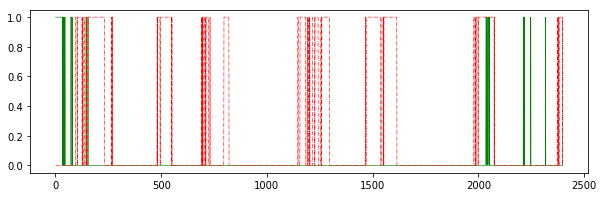

In [14]:
plt.figure(figsize=(10,3))
plt.plot(pred_y, 'g', lw=.6)
plt.plot(y[1:ntraining], '-.r', lw=0.6)

**Moving average up and down trends time frequency analysis**

In [74]:
# feature importance based on highest weights of first (entered) layer
ifeature = np.mean(np.apply_along_axis(abs, arr=w1s, axis=0), axis=1)
#plt.plot(ifeature)
#plt.plot(181, 0.3, 'r.')
print('most importante features :', Xtrain.columns.values[np.argsort(ifeature)[::-1]-1])

NameError: name 'Xtrain' is not defined

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(epochs):
        epoch_cost, epoch_accuracy = 0,0
        for j in range(num_batches):
            sess.run(op_train,
                     feed_dict={X:train_X[j*batch_size:(j+1)*batch_size],
                                Y:train_Y[j*batch_size:(j+1)*batch_size]})
            actual_batch_size = train_X[j*batch_size:(j+1)*batch_size].shape[0]
            epoch_cost += actual_batch_size*sess.run(
                cost,feed_dict={X:train_X[j*batch_size:(j+1)*batch_size],Y:train_Y[j*batch_size:(j+1)*batch_size]})
        epoch_cost = epoch_cost/float(train_X.shape[0])
        epoch_accuracy = np.mean(np.argmax(sess.run(out,feed_dict={X:train_X,Y:train_Y}), axis=1) == np.argmax(train_Y,axis=1))
        epoch_cost_trace.append(epoch_cost)
        epoch_accuracy_trace.append(epoch_accuracy)
        if (((i +1) >= 100) and ((i+1) % 100 == 0 )) :
            print('Epoch:',(i+1),'Average loss:',epoch_cost,'accuracy:',epoch_accuracy)
            print('Final epoch training results:','Average loss:',epoch_cost,'accuracy:',epoch_accuracy)
    loss_test = sess.run(cost,feed_dict={X:test_X,Y:test_Y})
    test_pred = np.argmax(sess.run(out,feed_dict={X:test_X,Y:test_Y}),axis=1)
    accuracy_test = np.mean(test_pred == np.argmax(test_Y,axis=1))
    print('Results on test dataset:','Average loss:',loss_test,'accuracy:',accuracy_test)

,ABEV3_O,ABEV3_H,ABEV3_L,ABEV3_C,BBDC4_O,BBDC4_H,BBDC4_L,BBDC4_C,BVMF3_O,BVMF3_H,...,rsi_5VALE3_C,ABEV3_O+ABEV3_H,ABEV3_H+ABEV3_L,ABEV3_L+ABEV3_C,BBDC4_O+BBDC4_H,BBDC4_H+BBDC4_L,BBDC4_L+BBDC4_C,BVMF3_O+BVMF3_H,BVMF3_H+BVMF3_L,BVMF3_L+BVMF3_C
1,0.163701,0.163701,0.162322,0.162322,0.056975,0.056916,0.057015,0.056955,0.045556,0.045556,...,0.562599,0.163701,0.162515,0.162322,0.056985,0.056842,0.057005,0.045290,0.045303,0.045606
2,0.163701,0.163701,0.162322,0.164692,0.057320,0.056916,0.057360,0.057301,0.046111,0.045556,...,0.566670,0.163701,0.162515,0.163507,0.057158,0.057015,0.057350,0.045568,0.045581,0.046162
3,0.164887,0.163701,0.163507,0.163507,0.057320,0.056916,0.057706,0.057301,0.046111,0.045556,...,0.570735,0.164294,0.163108,0.163507,0.057158,0.057187,0.057523,0.045568,0.045859,0.046162
4,0.163701,0.162515,0.162322,0.161137,0.057320,0.057261,0.057706,0.057301,0.046667,0.046111,...,0.566354,0.163108,0.161922,0.161730,0.057330,0.057360,0.057523,0.046124,0.046137,0.046440
5,0.161329,0.162515,0.162322,0.161137,0.057320,0.057261,0.057706,0.057301,0.047222,0.046111,...,0.566354,0.161922,0.161922,0.161730,0.057330,0.057360,0.057523,0.046402,0.046415,0.046997
6,0.161329,0.161329,0.161137,0.162322,0.057666,0.057261,0.057360,0.057301,0.047222,0.046111,...,0.570441,0.161329,0.160735,0.161730,0.057503,0.057187,0.057350,0.046402,0.044747,0.043938
7,0.162515,0.162515,0.162322,0.161137,0.057320,0.057606,0.057706,0.057646,0.044444,0.043889,...,0.566038,0.162515,0.161922,0.161730,0.057503,0.057533,0.057696,0.043901,0.043913,0.044494
8,0.161329,0.162515,0.162322,0.163507,0.058011,0.057606,0.058051,0.057991,0.045000,0.045000,...,0.566038,0.161922,0.161922,0.162915,0.057848,0.057706,0.058041,0.044735,0.045025,0.045328
9,0.162515,0.162515,0.159953,0.159953,0.058011,0.057951,0.057706,0.057301,0.046111,0.045000,...,0.570147,0.162515,0.160735,0.159953,0.058021,0.057706,0.057523,0.045290,0.045025,0.045050
10,0.161329,0.160142,0.158768,0.158768,0.057320,0.057261,0.057706,0.057646,0.045000,0.045000,...,0.570147,0.160735,0.158956,0.158768,0.057330,0.057360,0.057696,0.044735,0.045025,0.045050
